# Lab 2 - Regression, DiD, and Fixed Effects
- **Author:** Suraj R. Nair ([suraj.nair@berkeley.edu](mailto:suraj.nair@berkeley.edu))
- **Date:** January 28, 2025
- **Course:** INFO 251: Applied machine learning

### Topics:
1. Linear/ Multivariate Regression
2. T-tests
3. Dummy variables

### References: 
 * [Statsmodels](http://www.statsmodels.org/stable/example_formulas.html#loading-modules-and-functions) 
 * [Interpreting regression coefficients](https://dss.princeton.edu/online_help/analysis/interpreting_regression.htm)
 * [Card and Krueger (1994)](https://davidcard.berkeley.edu/papers/njmin-aer.pdf)
 * Fixed Effects:
      - [Panel Data and Fixed Effects in Python](https://matheusfacure.github.io/python-causality-handbook/14-Panel-Data-and-Fixed-Effects.html)
      - [Notes](https://www.jblumenstock.com/files/courses/econ174/FEModels.pdf) on fixed effects

### Import libraries

In [70]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline  

# The packages you'll need for regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Package for t-tests
from scipy import stats


# Confirm that pandas version is greater than 2
# the default return value for pd.get_dummies is bool for pandas > 2.0.0 
# python_version = int(pd.__version__.split(".")[0])
# assert python_version >= 2, "Ensure pandas version >=2.0.0" 

### Load the data

Card and Krueger (1994) collected survey data on employment in fast food restaurants in New Jersey and Pennsylvania in 1992. The data for today's lab uses a subset of the variables they collected.

- *UNIQUE_ID*: Unique ID for the restaurant interviewed
- *PERIOD*: 0 for pre-period (March 1994), 1 for post-period (December 1994)
- *STATE*: 0 for Pennsylvania, 1 for New Jersey
- *REGION*: Region code: 1 = Southern NJ, 2 = Central NJ, 3 = Northern NJ, 4 = Northeast Philly suburbs, 5 = Easton area, 6 = NJ Shore
- *CHAIN*: Chain restaurant code: 1 = Burger King, 2 = KFC, 3 = Roy's, 4 = Wendy's
- *EMP*: Number of employees (fulltime or parttime)
- *CO_OWNED*: 1 if company-owned
- *BONUS*: 1 if employees get a signing bonus
- *HRSOPEN*: Hours open per day, up to 24
- *NREGS*: Number of registers

In [4]:
df = pd.read_csv('fastfood.csv')
df.head()

,UNIQUE_ID,PERIOD,STATE,REGION,CHAIN,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS
0,46.0,0,0.0,4,1.0,45.0,0.0,1.0,16.5,3.0
1,49.0,0,0.0,4,2.0,13.0,0.0,0.0,13.0,4.0
2,506.0,0,0.0,4,2.0,10.0,1.0,0.0,10.0,3.0
3,56.0,0,0.0,4,4.0,40.0,1.0,1.0,12.0,2.0
4,61.0,0,0.0,4,4.0,32.0,1.0,1.0,12.0,2.0


In [5]:
df.tail()

,UNIQUE_ID,PERIOD,STATE,REGION,CHAIN,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS
785,423.0,1,1.0,3,2.0,22.5,1.0,1.0,12.0,3.0
786,424.0,1,1.0,3,2.0,15.0,1.0,0.0,11.0,5.0
787,426.0,1,1.0,3,3.0,30.0,1.0,0.0,19.0,5.0
788,427.0,1,1.0,3,4.0,35.0,0.0,0.0,12.5,2.0
789,428.0,1,1.0,3,4.0,34.0,0.0,0.0,12.5,2.0


In [6]:
#Create a variable identifying the pre-treatment period, and post-treatment period
pre = df[df['PERIOD'] == 0].copy()
post = df[df['PERIOD'] == 1].copy()

## 1. Warm Up: Exploratory analysis

**To do**:
- Find the correlation between the number of employees (EMP) and the hours open per day (HRSOPEN). 
- Generate a scatterplot with HRSOPEN on the x axis, and EMP on the y axis. Ensure that you label your axes, add a title etc. 

In [71]:
# Find the correlation between number of employees (EMP) and .
print(np.corrcoef(pre['HRSOPEN'], pre['EMP'])[0][1])

#Pandas also has a built correlation function
pre[['HRSOPEN', 'EMP']].corr()

0.5607581039654648


,HRSOPEN,EMP
HRSOPEN,1.000000,0.560758
EMP,0.560758,1.000000


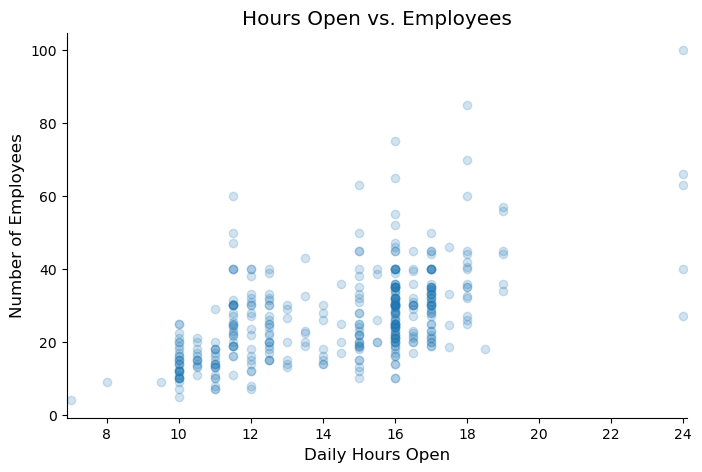

In [8]:
fig = plt.figure(figsize=(8, 5))
plt.scatter(pre['HRSOPEN'], pre['EMP'], alpha=.2)
plt.xlabel('Daily Hours Open', fontsize='large')
plt.ylabel('Number of Employees', fontsize='large')
plt.title('Hours Open vs. Employees', fontsize='x-large')
plt.xlim(6.9, 24.1)
sns.despine()
plt.show()

## 2.  Linear regression with statsmodels

As we discussed in class, linear regression provides us a concise summary of one variable as a function of another variables(s) through two types of parameters - the slope and the intercept. We'll start by exploring the relationship between employment and the number of hours a restaurant is open in the **pre-period**.

**To do**: 
- run a regression where the dependent variable is the number of employees (EMP), and the independent variable is the hours open per day (HRSOPEN). 
- pair up with a classmate seated near you. discuss the interpretations of the slope and intercept coefficients. 

In [18]:
# Syntax option 1
x, y = pre['HRSOPEN'].values, pre['EMP'].values # x is the input variable, y is the output variable
x = sm.add_constant(x) # Add a constant for the intercept term
model1 = sm.OLS(y, x).fit() # Note the order of y folowed by x!
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     182.1
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.02e-34
Time:                        22:09:16   Log-Likelihood:                -1494.8
No. Observations:                 399   AIC:                             2994.
Df Residuals:                     397   BIC:                             3002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6277      2.689     -3.209      0.0

In [19]:
# Syntax option 2
model2 = smf.ols(formula='EMP ~ HRSOPEN', data=pre).fit() # Automatically includes the intercept term
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     182.1
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.02e-34
Time:                        22:09:18   Log-Likelihood:                -1494.8
No. Observations:                 399   AIC:                             2994.
Df Residuals:                     397   BIC:                             3002.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6277      2.689     -3.209      0.0

## 3. Difference in means, linear regression, and t-tests

Our goal is to answer a simple question: prior to the increase in minimum wage, do restaurants in New Jersey employ more workers than restaurants in Pennsylvania on average? It's fine to eyeball the data to answer this initially, but our goal is to arrive at a more robust conclusion via the use of some statistical tests. 

To do:

1. Calculate mean difference in the number of employees (EMP) between New Jersey (STATE == 1) and Pennsylvania (STATE == 0) in the pre-period.
2. Run a t-test to determine if the the difference between these two groups is statistically significant. One way to do this is to use the scipy function [*ttest_ind*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). 
3. Finally, run a regression where the dependent / outcome variable is the number of employees (EMP), and the independent variable is the state (STATE). 

Pair up with a classmate seated near you. Discuss the following:
- For the statistical test(s) you've set up, what are the null and alternate hypotheses?
- Compare the intercept and slope coefficient from the regression in 3 to your results in 1. What do you observe?
- Compare the t-statistic and the corresponding p-value for the slope coefficient (from 3) to your results in 2. What do you observe, and why?
- Prior to the increase in minimum wage, do restaurants in New Jersey employ more workers than restaurants in Pennsylvania?


In [28]:
pre[pre['STATE'] == 1]['EMP'].mean() - pre[pre['STATE'] == 0]['EMP'].mean()

-3.3683201533668843

In [42]:
stats.ttest_ind(pre[pre['STATE'] == 1]['EMP'], pre[pre['STATE'] == 0]['EMP'])

Ttest_indResult(statistic=-2.1622602024403994, pvalue=0.031194832403291045)

In [27]:
m = smf.ols("EMP ~ STATE", data = pre).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    EMP   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.675
Date:                Tue, 28 Jan 2025   Prob (F-statistic):             0.0312
Time:                        22:44:31   Log-Likelihood:                -1567.8
No. Observations:                 399   AIC:                             3140.
Df Residuals:                     397   BIC:                             3148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.6923      1.397     21.251      0.000      26.945      32.439
STATE         -3.3683      1.558     -2.162      0.031      -6.431      -0.306
==============================================================================
Omnibus:                      124.338   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.665
Skew:                           1.379   Prob(JB):                     4.11e-95
Kurtosis:                       7.306   Cond. No.                         4.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4. Multivariate Regression

Let's extend our analysis to include more explanatory variables. 

 - Run a regression where the outcome / dependent variable is the number of employees (EMP), while the RHS / independent variables are the number of hours open (HRSOPEN), whether or not employees get a bonus (BONUS), and the region (REGION).
 - Think carefully about how you would handle the categorical variable REGION. The [statsmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html#Categorical-variables) will be useful. 
 - Pair up with a classmate seated near near you. Discuss your results, and the interpretations for each of the coefficients. 

In [72]:
# Syntax 2
model = smf.ols(formula='EMP ~ HRSOPEN + BONUS + C(REGION)', data=pre).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     39.25
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.50e-37
Time:                        23:26:21   Log-Likelihood:                -1476.3
No. Observations:                 399   AIC:                             2967.
Df Residuals:                     392   BIC:                             2994.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -13.4909      2.712     -4.

### 5. Dummy variables / One-hot encoding

You'll encounter one-hot encoding at various points throughout your journey learning / using machine learning, so no time like the present to get in some practice!

For this exercise, focus on the categorical variable CHAIN, which describes the type restaurant (Chain restaurant code: 1 = Burger King, 2 = KFC, 3 = Roy's, 4 = Wendy's) 

**To do**

1. Implement one-hot encoding / generate a set of dummy variables for each category in the variable CHAIN. One way to implement this involves using the pandas [*get_dummies()*](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function. 
2. Run a regression where the independent variable is the number of employees (EMP), while the indepent variables are the one-hot encoded / dummy variables created in step 1 above. Ensure that you drop at least one of the dummy variables. 
3. Now, run a regression where the independent variable is the number of employees (EMP), while the indepent variables are the one-hot encoded / dummy variables created in step 1 above. This time, include all the dummy variables, but drop the constant. 

Pair up with a classmate seated near you. Discuss:

- Why is it important to drop one of the dummy variables in 2? What happens if you do not do this?
- Compare your results in 2 and 3:
    - What is the interpretation of the intercept term in 2?
    - How does the interpretation of the coefficients in 3 differ, relative to the interpretation of the coefficients in 2? 



In [53]:
# Get dummy variables for CHAIN
pre['CHAIN'] = pre['CHAIN'].astype(int)
dummy_pre = pd.get_dummies(pre, columns=['CHAIN']) # Pandas' default is not to drop a column
dummy_pre.head()

,UNIQUE_ID,PERIOD,STATE,REGION,EMP,CO_OWNED,BONUS,HRSOPEN,NREGS,CHAIN_1,CHAIN_2,CHAIN_3,CHAIN_4
0,46.0,0,0.0,4,45.0,0.0,1.0,16.5,3.0,1,0,0,0
1,49.0,0,0.0,4,13.0,0.0,0.0,13.0,4.0,0,1,0,0
2,506.0,0,0.0,4,10.0,1.0,0.0,10.0,3.0,0,1,0,0
3,56.0,0,0.0,4,40.0,1.0,1.0,12.0,2.0,0,0,0,1
4,61.0,0,0.0,4,32.0,1.0,1.0,12.0,2.0,0,0,0,1


**CODE UPDATE**: Note that for pandas versions >= 2.0.0, we need to specify "dtype = int" in the pd.get_dummies() function

In [59]:
# Regression with a dummy variable: Syntax option 1
m4 = smf.ols('EMP ~ CHAIN_2 + CHAIN_3 + CHAIN_4', dummy_pre).fit()
print(m4.summary())

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     39.61
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.12e-22
Time:                        23:14:49   Log-Likelihood:                -1517.6
No. Observations:                 399   AIC:                             3043.
Df Residuals:                     395   BIC:                             3059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.4759      0.847     35.989      0.0

In [58]:
# Regression with a dummy variable: Syntax option 2

# Statsmodels formula API automatically drops one of the dummies
print(smf.ols(formula='EMP ~ C(CHAIN)', data=pre).fit().summary()) 

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     39.61
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.12e-22
Time:                        23:14:24   Log-Likelihood:                -1517.6
No. Observations:                 399   AIC:                             3043.
Df Residuals:                     395   BIC:                             3059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        30.4759      0.847     35.989

 - Now run the regression again, this time dropping the constant. What do you observe? How have the coefficients changed?

In [61]:
#Drop the constant
print(smf.ols(formula='EMP ~ C(CHAIN) - 1', data=pre).fit().summary()) 

                            OLS Regression Results                            
Dep. Variable:                    EMP   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     39.61
Date:                Tue, 28 Jan 2025   Prob (F-statistic):           2.12e-22
Time:                        23:15:03   Log-Likelihood:                -1517.6
No. Observations:                 399   AIC:                             3043.
Df Residuals:                     395   BIC:                             3059.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
C(CHAIN)[1]    30.4759      0.847     35.989      

## FOR NEXT WEEK

### 6. Differences-in-differences


Use a differences-in-differences regression specification to estimate the impact of the increase in the minimum wage in New Jersey (state == 1) between the pre- and the post-period (period==1). 

Remember the diff-in-diff regression specification: Y = B0 + B1 * Time + B2 * Intervention + B3*(Time*Intervention)

**QUESTION**: Interpret the regression coefficients in terms of the impact of the minimum wage change on employment.

**QUESTION**: Why might you want to add control variables to this regression?

### 7. Interaction Terms

An interaction term captures the notion that the value of a variable is influenced by the value of another variables. 

In [ ]:
model1 = smf.ols(formula='EMP ~ HRSOPEN + BONUS + HRSOPEN * BONUS ', data=pre).fit()
print(model1.summary())

**QUESTION**: Interpret the coefficients

**QUESTION**: Create a plot which demonstrates how the variable BONUS influences the value of HRSOPEN

### 8: Fixed Effects Intuition

Let's create a toy dataset for this example, with these variables:

    - city: New York, Chicago, San Francisco, Washington D.C
    - year: 2020, 2021, 2022, 2023, 2024
    - quantity: the amount purchased (of some arbitrary good)
    - price: the cost of the arbitrary good, varying by year and city. 
   

In [63]:

df_panel = pd.DataFrame({
    "quantity": [25, 24.3, 23, 20,
                 15, 13.8, 12.5, 13,
                 20, 19, 18, 19,
                 22, 19.5, 19, 19,
                ],
    "price": [5.0, 5.34, 5.47, 5.51, 
              4.01, 4.35, 4.43, 4.43, 
              4.50, 4.62, 4.70, 4.89, 
             4.80, 4.90, 4.95, 5.25
             ],
    "year":[2020, 2021, 2022, 2023]*4,
    "city":  ['New York']*4 +  
             ["Chicago"]*4 + 
             ["San Francisco"]*4 + 
             ["Washington D.C."]*4
})


Let's explore a cross-section of this data, say in the year 2022.  

In [64]:
### View the data

df_panel[df_panel['year'] == 2022]

,quantity,price,year,city
2,23.0,5.47,2022,New York
6,12.5,4.43,2022,Chicago
10,18.0,4.70,2022,San Francisco
14,19.0,4.95,2022,Washington D.C.


Simply looking over this data, it actually appears the quantity purchased appears to increase along with prices. Does that make sense?. 

What might explain this? On the one hand, perhaps the quality of the good is higher in certain cities. For example, if the **good** in question is a bagel, perhaps the best bagels are found in New York (ahem, Boichik)? Alternatively, there might simply be a high demand for bagels in New York, thus explaining the high prices. 

But simply put, we can't say much about the role of price here -- since we do not have data for quality, or bagel obsession.. Running a regression to further examine the relationship between quantity and price is likely to thus suffer from omitted variable bias.

To hammer home this point, let's explore the relationship between quantity and price using a univariate regression, across the entire sample. What do you get?

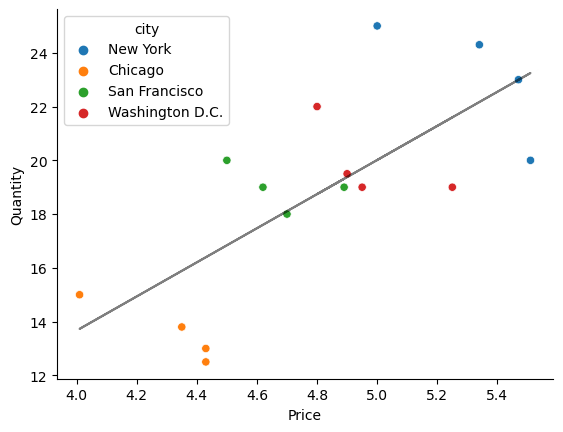

In [65]:
m = smf.ols("quantity ~ price", data = df_panel).fit()

sns.scatterplot(data = df_panel, x=  'price', y = 'quantity', hue = "city")
plt.plot(df_panel['price'], m.fittedvalues, "k-", alpha = 0.5, label="Regression Line")
plt.xlabel("Price")
plt.ylabel("Quantity")
sns.despine()
plt.show()

Now, let's examine the full dataset. 

In [66]:
df_panel

,quantity,price,year,city
0,25.0,5.00,2020,New York
1,24.3,5.34,2021,New York
2,23.0,5.47,2022,New York
3,20.0,5.51,2023,New York
4,15.0,4.01,2020,Chicago
5,13.8,4.35,2021,Chicago
6,12.5,4.43,2022,Chicago
7,13.0,4.43,2023,Chicago
8,20.0,4.50,2020,San Francisco
9,19.0,4.62,2021,San Francisco


We see that as price increases, the quantity purchased decreases **within** each city. This is reasonable, as we would expect the demand to fall as price increases.

This provides the underlying intuition for fixed effects. In the cross-section we saw earlier, a regression that primarily relied on variation across cities is problematic, due to omitted variables bias. The solution is to focus on **within** city variation, relying on the panel structure of the data to remove the effect of omitted variable bias.

We still have to make a key assumption here, however. What is it?

Now, let's examine a simple fixed effects model, where we eliminate the unobserved variation across cities, and focus only on within city variation. A simple way to achieve this, as you saw in lecture, is to add a dummy variable for each city. So let's go ahead and try that below. 

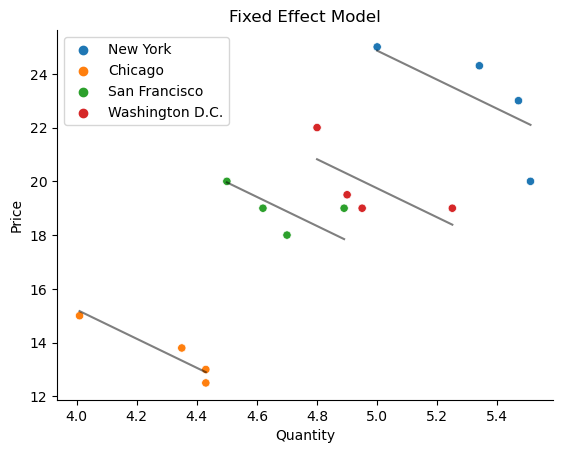

In [67]:
#C() is used to tell statsmodels that the variable in question is a categorical/ factor variable
fe = smf.ols("quantity ~ price + C(city)", data=df_panel).fit()  

df_panel['y_hat'] = fe.fittedvalues

sns.scatterplot(data = df_panel, x = 'price', y = 'quantity', hue = 'city')
for city in df_panel["city"].unique():
    plt_df = df_panel[df_panel["city"] == city]
    plt.plot(plt_df['price'], plt_df['y_hat'], "k-", alpha = 0.5)

plt.title("Fixed Effect Model")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.legend(loc = "best")
sns.despine()
plt.show()

Notice that we are effectively fitting one regression line per city. This is what the ''city'' fixed effect does -- it controls for the average (time invariant) differences across cities (in observable/ unobservable variables). 